In [1]:
import matplotlib.pyplot as plt
import numpy as np

plt.ion()

In [2]:
from pde import (
    UnitGrid,
    CartesianGrid,
    PolarSymGrid,
    SphericalSymGrid,
    ScalarField,
    VectorField,
    FieldCollection,
    DiffusionPDE,
    CahnHilliardPDE,
    PlotTracker,
    PrintTracker,
    MemoryStorage,
    FileStorage,
    KPZInterfacePDE,
    solve_poisson_equation,
    PDE,
    PDEBase,
    ExplicitSolver,
    Controller,
    ScipySolver,
    CylindricalSymGrid,
)

In [3]:
plt.rcParams["text.usetex"] = True
plt.rcParams["font.serif"] = ["Computer Modern"]
np.set_printoptions(
    precision=1, suppress=True, formatter={"float": "{:0.1f}".format}, linewidth=50
)

## Grids

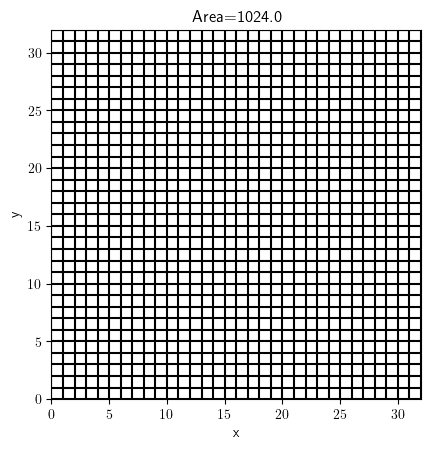

In [4]:
grid = UnitGrid(shape=[32, 32])
grid.plot(title=f"Area={grid.volume}")

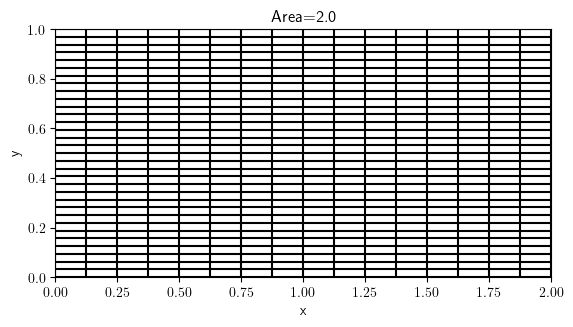

In [5]:
grid = CartesianGrid(bounds=[[0, 2], [0, 1]], shape=[16, 32])
grid.plot(title=f"Area={grid.volume}")

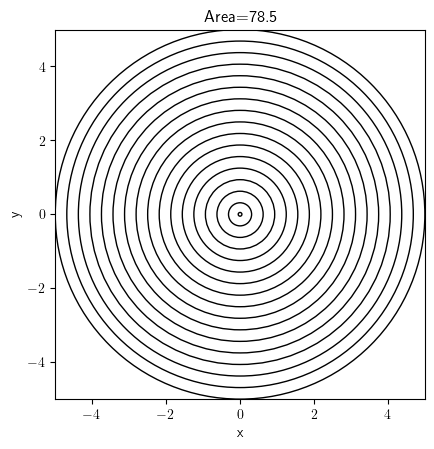

In [6]:
grid = PolarSymGrid(radius=5, shape=16)
grid.plot(title=f"Area={grid.volume:.3g}")

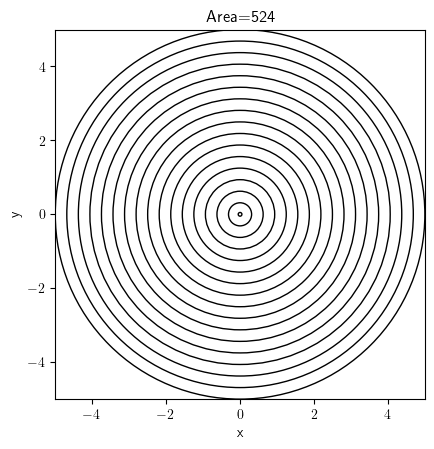

In [7]:
grid = SphericalSymGrid(radius=5, shape=16)
grid.plot(title=f"Area={grid.volume:.3g}")

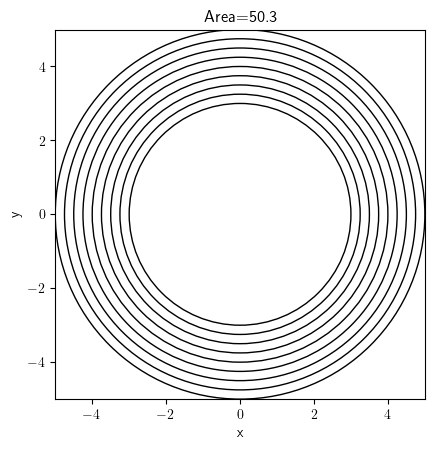

In [8]:
grid = PolarSymGrid(radius=(3, 5), shape=8)
grid.plot(title=f"Area={grid.volume:.3g}")

## Fields

In [9]:
grid = CartesianGrid(bounds=[[0, 4 * np.pi], [0, 2 * np.pi]], shape=[128, 32])
field = ScalarField(grid, data=1)

In [10]:
print(field.data)

[[1.0 1.0 1.0 ... 1.0 1.0 1.0]
 [1.0 1.0 1.0 ... 1.0 1.0 1.0]
 [1.0 1.0 1.0 ... 1.0 1.0 1.0]
 ...
 [1.0 1.0 1.0 ... 1.0 1.0 1.0]
 [1.0 1.0 1.0 ... 1.0 1.0 1.0]
 [1.0 1.0 1.0 ... 1.0 1.0 1.0]]


In [11]:
field += 4

In [12]:
print(field.data)

[[5.0 5.0 5.0 ... 5.0 5.0 5.0]
 [5.0 5.0 5.0 ... 5.0 5.0 5.0]
 [5.0 5.0 5.0 ... 5.0 5.0 5.0]
 ...
 [5.0 5.0 5.0 ... 5.0 5.0 5.0]
 [5.0 5.0 5.0 ... 5.0 5.0 5.0]
 [5.0 5.0 5.0 ... 5.0 5.0 5.0]]


In [13]:
grid = CartesianGrid(bounds=[[0, 4 * np.pi], [0, 2 * np.pi]], shape=[128, 32])
data = np.arange(128 * 32).reshape(grid.shape)
field = ScalarField(grid, data=data)

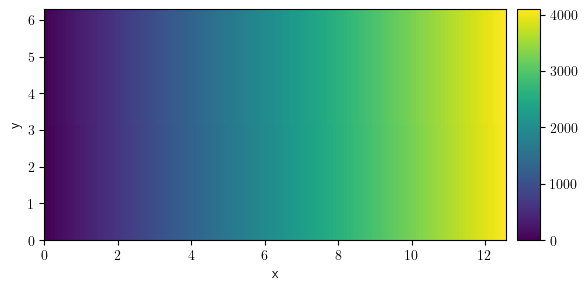

In [14]:
field.plot(colorbar=True)

In [15]:
print(field.data)

[[0.0 1.0 2.0 ... 29.0 30.0 31.0]
 [32.0 33.0 34.0 ... 61.0 62.0 63.0]
 [64.0 65.0 66.0 ... 93.0 94.0 95.0]
 ...
 [4000.0 4001.0 4002.0 ... 4029.0 4030.0 4031.0]
 [4032.0 4033.0 4034.0 ... 4061.0 4062.0 4063.0]
 [4064.0 4065.0 4066.0 ... 4093.0 4094.0 4095.0]]


In [16]:
field.interpolate([2.1, 0.3])

array(669.5)

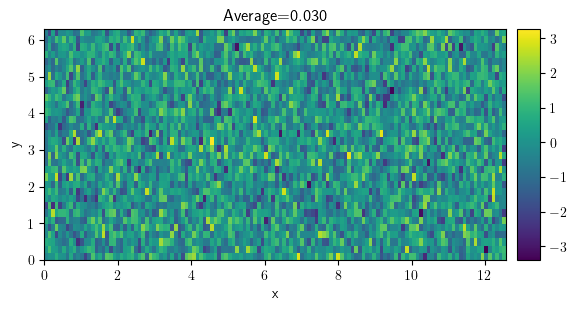

In [17]:
field = ScalarField.random_normal(grid=grid)
field.plot(title=f"Average={field.average:.3f}", colorbar=True);

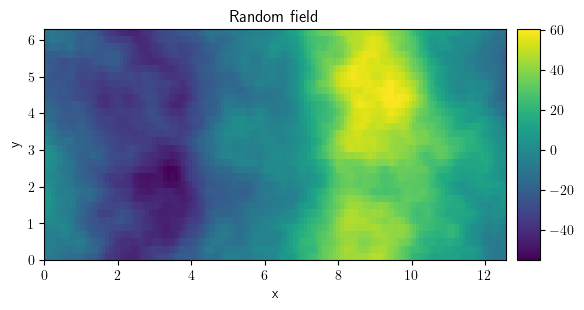

In [18]:
field = ScalarField.random_colored(grid=grid, exponent=-4, label="Random field")
field.plot()

In [19]:
field.to_file("random_field.hdf")
!(ls random_field.hdf)

random_field.hdf


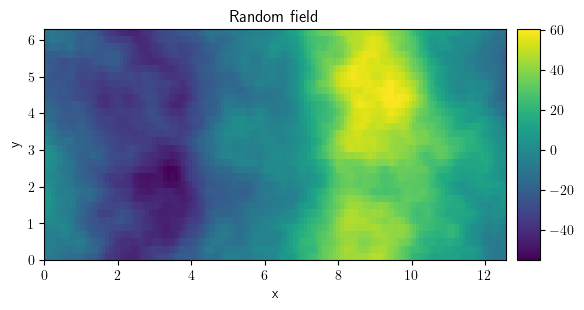

In [20]:
field_loaded = ScalarField.from_file("random_field.hdf")
field_loaded.plot()

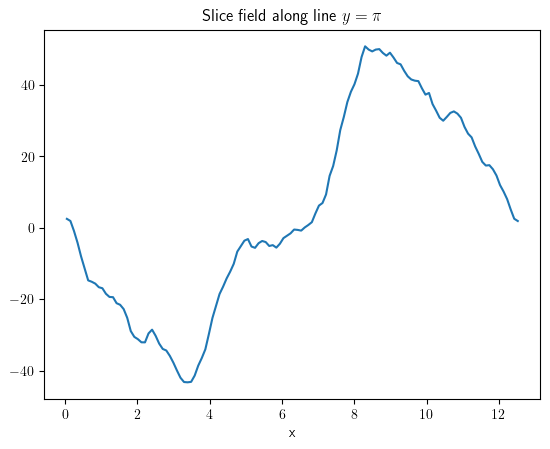

In [21]:
slice_x = field.slice({"y": np.pi})
slice_x.plot(title="Slice field along line $y=\pi$");

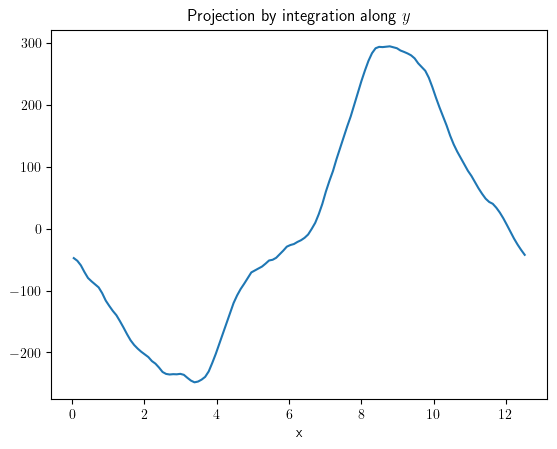

In [22]:
project_x = field.project("y")
project_x.plot(title="Projection by integration along $y$");

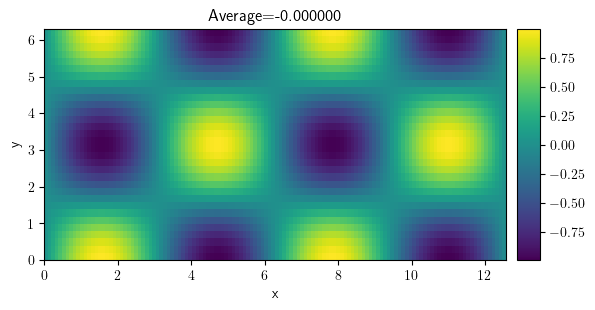

In [23]:
field = ScalarField.from_expression(grid=grid, expression="sin(x) * cos(y)")
field.plot(title=f"Average={field.average:f}", colorbar=True)

## Differential operators

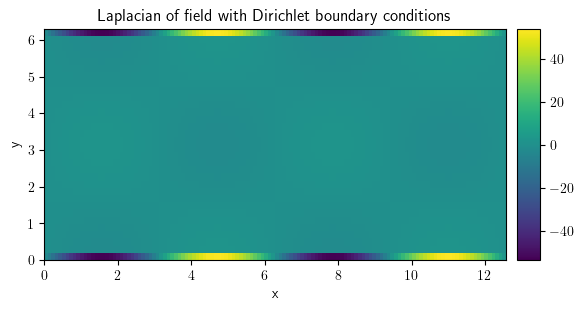

In [24]:
grid = CartesianGrid(bounds=[[0, 4 * np.pi], [0, 2 * np.pi]], shape=[128, 32])
field = ScalarField.from_expression(grid=grid, expression="sin(x) * cos(y)")
laplace_dir = field.laplace(bc={"value": 0})
laplace_dir.plot(
    title="Laplacian of field with Dirichlet boundary conditions", colorbar=True
);

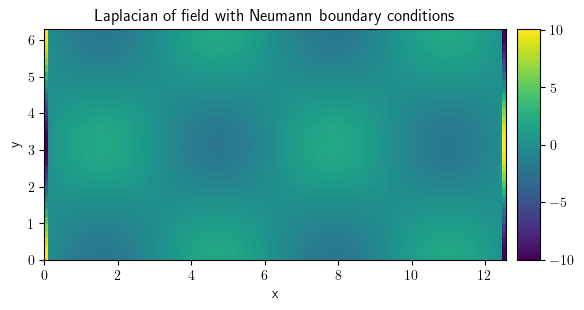

In [25]:
laplace_neu = field.laplace(bc={"derivative": 0})
laplace_neu.plot(
    title="Laplacian of field with Neumann boundary conditions", colorbar=True
)

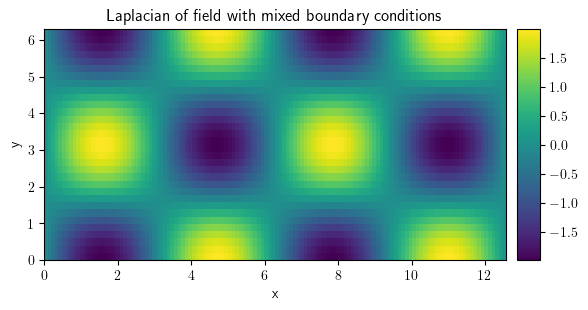

In [26]:
laplace_mix = field.laplace(bc=[{"value": 0}, {"derivative": 0}])
laplace_mix.plot(
    title="Laplacian of field with mixed boundary conditions", colorbar=True
)

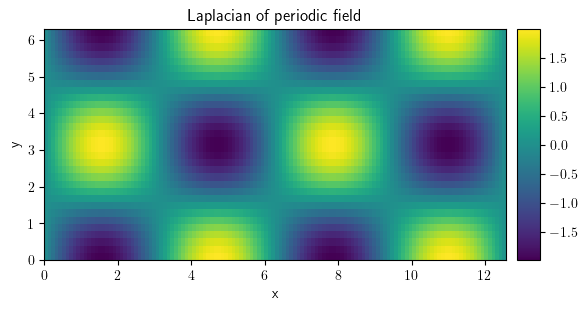

In [27]:
grid_per = CartesianGrid(
    bounds=[[0, 4 * np.pi], [0, 2 * np.pi]], shape=[128, 32], periodic=True
)
field_per = ScalarField.from_expression(grid=grid_per, expression="sin(x) * cos(y)")
laplace_per = field_per.laplace("periodic")
laplace_per.plot(title="Laplacian of periodic field", colorbar=True)

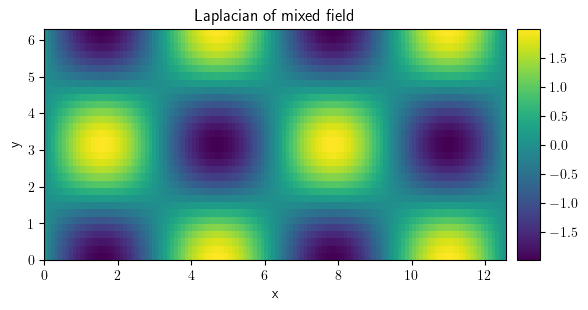

In [28]:
grid_mixed = CartesianGrid(
    bounds=[[0, 4 * np.pi], [0, 2 * np.pi]], shape=[128, 32], periodic=[True, False]
)
field_mixed = ScalarField.from_expression(grid=grid_mixed, expression="sin(x) * cos(y)")

laplace_mixed = field_mixed.laplace(bc=["periodic", {"derivative": 0}])
laplace_mixed.plot(title="Laplacian of mixed field", colorbar=True)

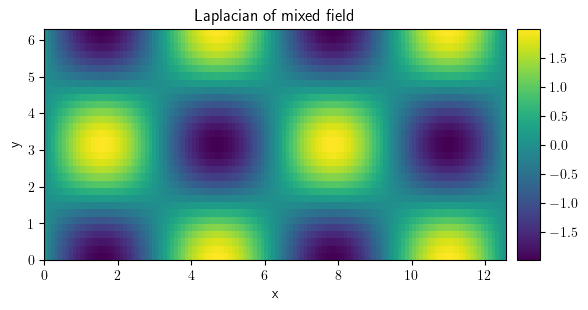

In [29]:
laplace_mixed = field_mixed.laplace(bc="natural")
laplace_mixed.plot(title="Laplacian of mixed field", colorbar=True)

## Vector Fields

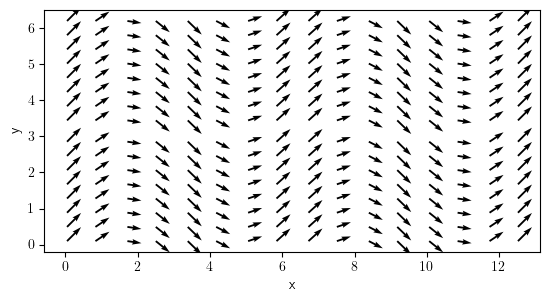

In [30]:
grid_per = CartesianGrid(
    bounds=[[0, 4 * np.pi], [0, 2 * np.pi]], shape=[128, 32], periodic=True
)
vector_field = VectorField.from_expression(grid=grid_per, expressions=["1", "cos(x)"])
vector_field.plot();

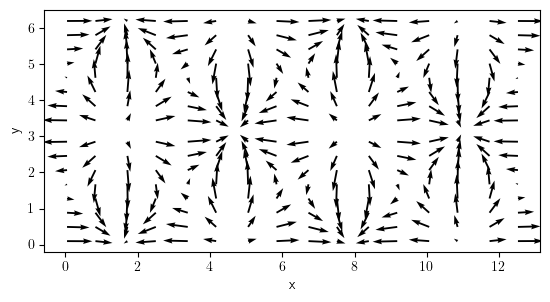

In [31]:
field_per = ScalarField.from_expression(grid=grid_per, expression="sin(x) * cos(y)")
field_grad = field_per.gradient("natural")
field_grad.plot()

In [32]:
print(field_grad.average)

[0.0 -0.0]


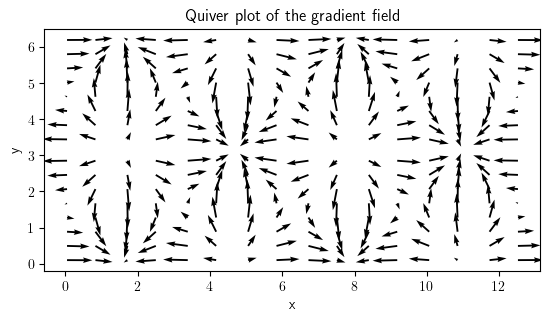

In [33]:
field_grad.plot(method="quiver", title="Quiver plot of the gradient field")

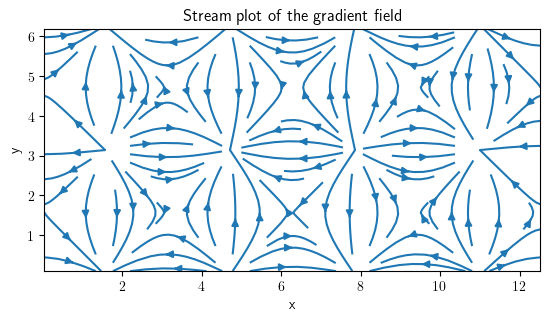

In [34]:
field_grad.plot(method="streamplot", title="Stream plot of the gradient field")

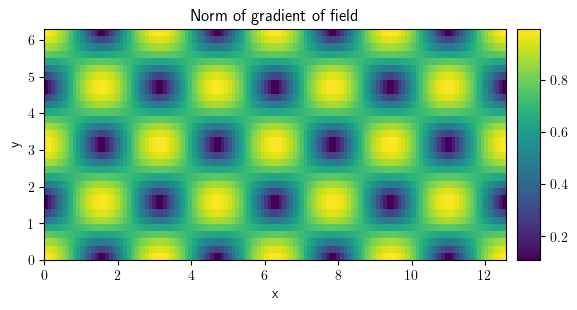

In [35]:
gradient_norm = field_grad.to_scalar("norm")
gradient_norm.plot(title="Norm of gradient of field", colorbar=True)

In [36]:
comp_x = field_grad[0]
comp_y = field_grad[1]

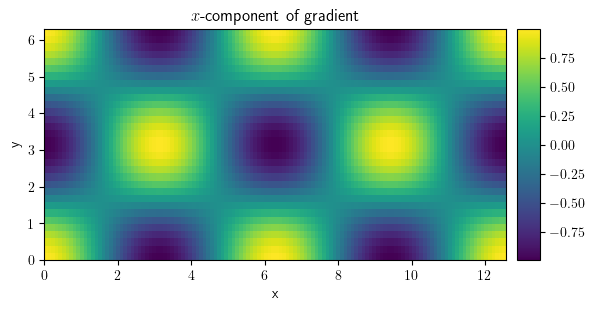

In [37]:
comp_x.plot(title="$x$-component of gradient", colorbar=True)

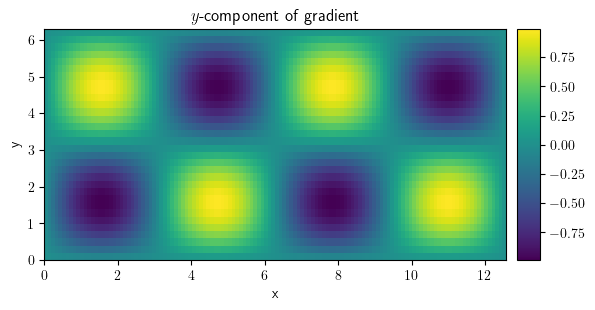

In [38]:
comp_y.plot(title="$y$-component of gradient", colorbar=True)

In [39]:
gradient_expl_norm = (comp_x**2 + comp_y**2) ** 0.5
np.allclose(gradient_expl_norm.data, gradient_norm.data)

True

In [40]:
field_hess = field_grad.gradient("natural", label="Hessian of field")
field_hess.attributes

{'class': 'Tensor2Field',
 'grid': CartesianGrid(bounds=((0.0, 12.566370614359172), (0.0, 6.283185307179586)), shape=(128, 32), periodic=[True, True]),
 'label': 'Hessian of field',
 'dtype': dtype('float64')}

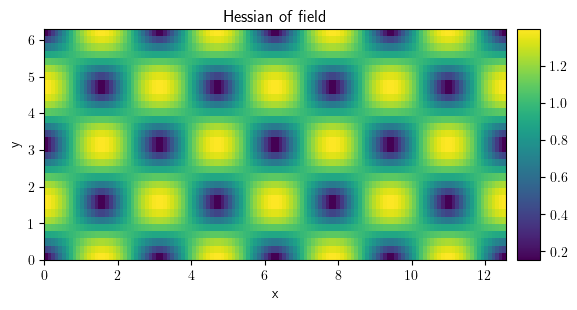

In [41]:
field_hess.plot()

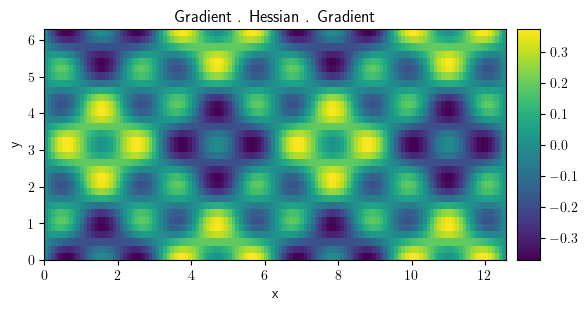

In [42]:
scalar_field = field_grad @ field_hess @ field_grad
scalar_field.plot(title="Gradient . Hessian . Gradient", colorbar=True)

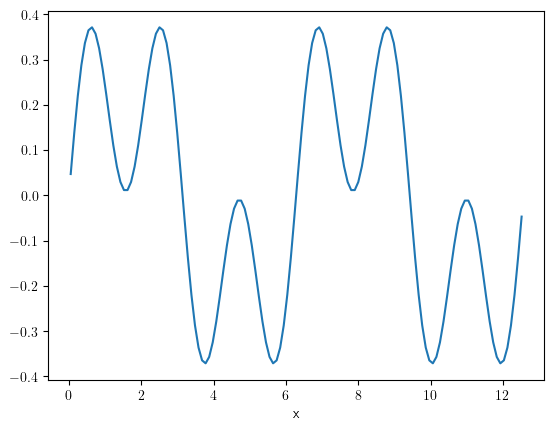

In [43]:
scalar_field.slice({"y": np.pi}).plot()

## Field collections

In [44]:
grid_pol = PolarSymGrid(radius=[2, 7], shape=32)
scalar_field1 = ScalarField.from_expression(
    grid=grid_pol, expression="r**2", label="Increasing"
)
scalar_field2 = ScalarField.from_expression(
    grid=grid_pol, expression="1/r", label="Decreasing"
)
collection = FieldCollection(fields=[scalar_field1, scalar_field2])

In [45]:
collection.attributes

{'class': 'FieldCollection',
 'label': None,
 'dtype': dtype('float64'),
 'fields': [{'class': 'ScalarField',
   'grid': PolarSymGrid(radius=(2, 7), shape=(32,)),
   'label': 'Increasing',
   'dtype': dtype('float64')},
  {'class': 'ScalarField',
   'grid': PolarSymGrid(radius=(2, 7), shape=(32,)),
   'label': 'Decreasing',
   'dtype': dtype('float64')}]}

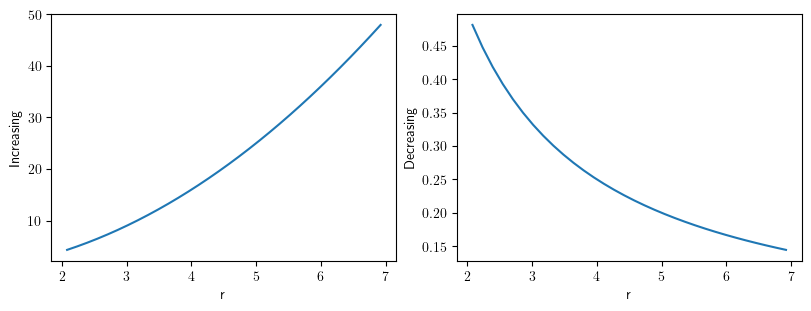

In [46]:
collection.plot()

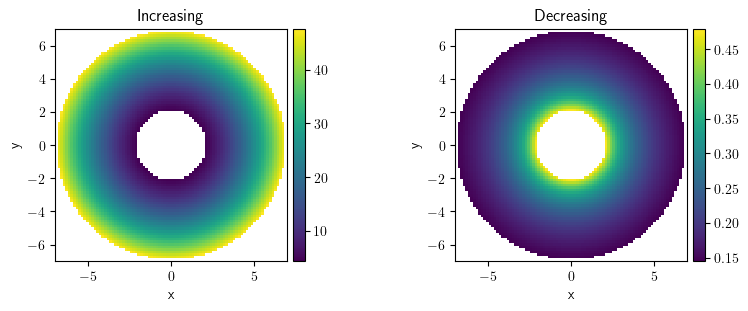

In [47]:
collection.plot("image")

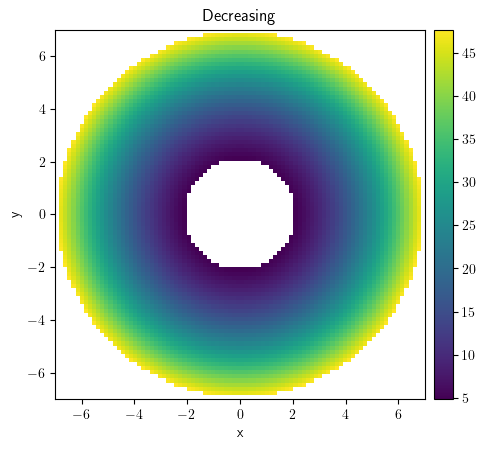

In [48]:
(collection[0] + collection[1]).plot("image")

In [49]:
grid = UnitGrid(shape=[96, 64])
sf = ScalarField.random_colored(grid=grid, exponent=-3)
vf = VectorField.random_harmonic(grid=grid, modes=1)
fc = FieldCollection(fields=[sf, vf])

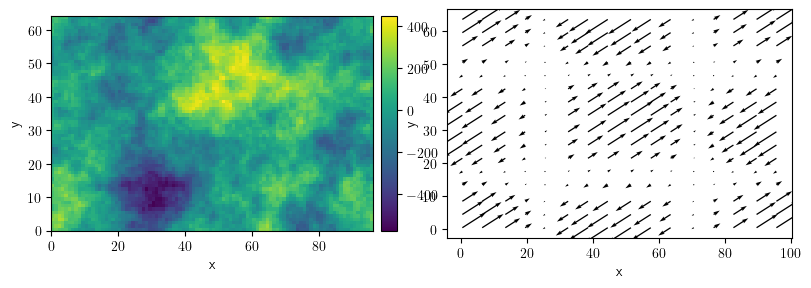

In [50]:
fc.plot()

## Solving PDEs

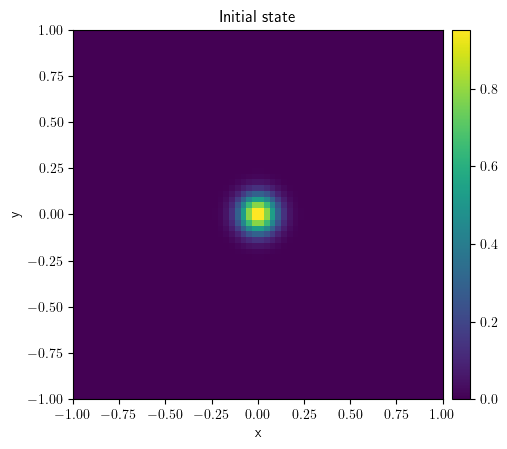

In [51]:
grid = CartesianGrid(bounds=[[-1, 1], [-1, 1]], shape=64)
state = ScalarField.from_expression(grid=grid, expression="exp(-(x**2 + y**2) * 100)")
state.plot(title="Initial state")

  0%|          | 0/1.0 [00:00<?, ?it/s]

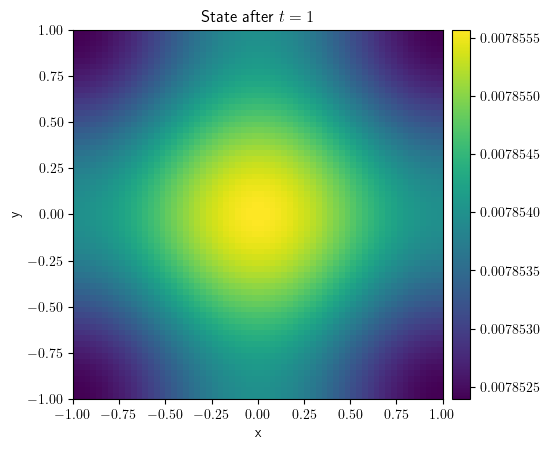

In [52]:
eq = DiffusionPDE()
result = eq.solve(state=state, t_range=1, dt=1e-4)
result.plot(title="State after $t=1$")

  0%|          | 0/100.0 [00:00<?, ?it/s]

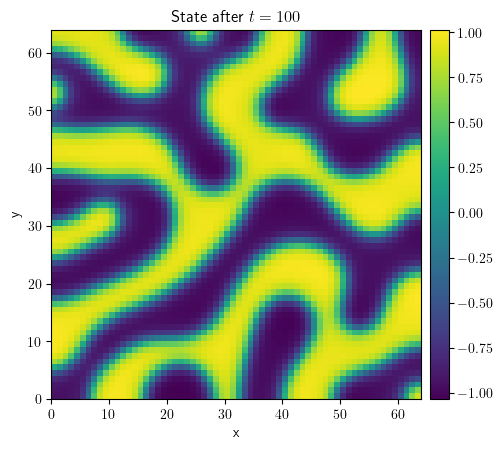

In [53]:
grid = UnitGrid(shape=[64, 64])
state = ScalarField.random_uniform(grid=grid, vmin=-1, vmax=1)
eq = CahnHilliardPDE()
result = eq.solve(state=state, t_range=1e2, dt=1e-3)
result.plot(title="State after $t=100$", colorbar=True)

  0%|          | 0/10.0 [00:00<?, ?it/s]

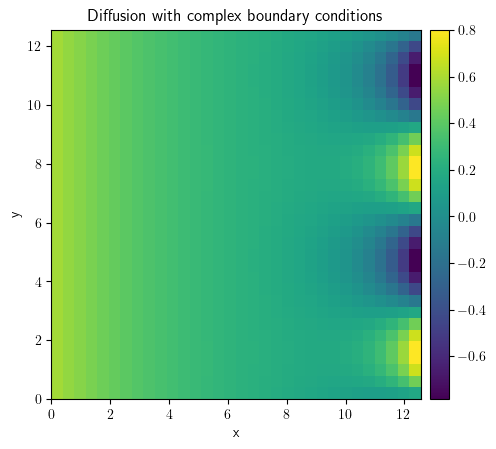

In [54]:
grid = CartesianGrid(
    bounds=[[0, 4 * np.pi], [0, 4 * np.pi]], shape=[32, 32], periodic=[False, True]
)
state = ScalarField.random_uniform(grid=grid, vmin=0.2, vmax=0.3)
bc_x_left = {"derivative": 0.1}
bc_x_right = {"value": "sin(y)"}
bc_x = [bc_x_left, bc_x_right]
bc_y = "periodic"
eq = DiffusionPDE(bc=[bc_x, bc_y])
result = eq.solve(state=state, t_range=10, dt=0.005)
result.plot(title="Diffusion with complex boundary conditions")

  0%|          | 0/0.1 [00:00<?, ?it/s]

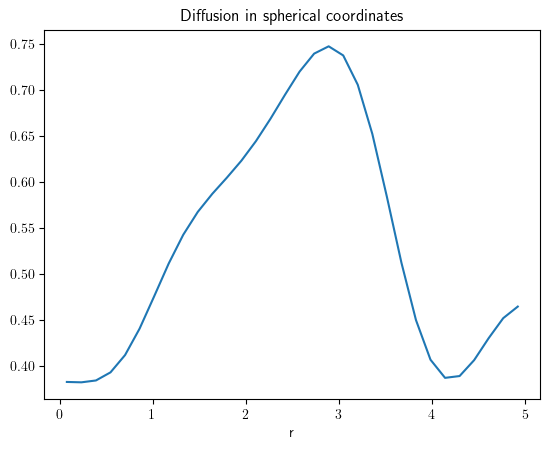

In [55]:
grid = SphericalSymGrid(radius=[0, 5], shape=32)
state = ScalarField.random_uniform(grid=grid)
eq = DiffusionPDE()
result = eq.solve(state=state, t_range=0.1, dt=0.005)
result.plot(title="Diffusion in spherical coordinates")

## Trackers

In [56]:
grid = UnitGrid(shape=[128, 128])
state = ScalarField.random_uniform(grid=grid, vmin=-0.5, vmax=0.5)
eq = CahnHilliardPDE()

In [57]:
eq.solve(state=state, t_range=1e3, dt=0.01, tracker=PlotTracker(interval=100))

Output()

Spent more time on handling trackers (15.8) than on the actual simulation (14.5)


ScalarField(grid=UnitGrid(shape=(128, 128), periodic=[False, False]), data=[[0.9 0.9 0.7 ... -1.0 -1.0 -1.0]
 [0.9 0.9 0.7 ... -1.0 -1.0 -1.0]
 [0.9 0.9 0.8 ... -0.9 -0.9 -0.9]
 ...
 [-1.0 -1.0 -1.0 ... 1.0 1.0 1.0]
 [-1.0 -1.0 -1.0 ... 1.0 1.0 1.0]
 [-1.0 -1.0 -1.0 ... 1.0 1.0 1.0]])

In [58]:
trackers = ["progress", PrintTracker(interval="0:01")]
eq.solve(state=state, t_range=1e3, dt=0.01, tracker=trackers)

  0%|          | 0/1000.0 [00:00<?, ?it/s]

t=0, c=-0.000877±0.291
t=0.01, c=-0.000877±0.246
t=0.03, c=-0.000877±0.202
t=0.2, c=-0.000877±0.128
t=1.44, c=-0.000877±0.115
t=7.92, c=-0.000877±0.297
t=25.54, c=-0.000877±0.62
t=52.36, c=-0.000877±0.709
t=90.73, c=-0.000877±0.758
t=141.67, c=-0.000877±0.789
t=189.38, c=-0.000877±0.804
t=236.61, c=-0.000877±0.816
t=297.38, c=-0.000877±0.827
t=356.37, c=-0.000877±0.84
t=416.41, c=-0.000877±0.848
t=479.72, c=-0.000877±0.857
t=543.69, c=-0.000877±0.865
t=617.75, c=-0.000877±0.87
t=691.05, c=-0.000877±0.875
t=764.44, c=-0.000877±0.877
t=845.83, c=-0.000877±0.88
t=932.32, c=-0.000877±0.883


ScalarField(grid=UnitGrid(shape=(128, 128), periodic=[False, False]), data=[[0.9 0.9 0.7 ... -1.0 -1.0 -1.0]
 [0.9 0.9 0.7 ... -1.0 -1.0 -1.0]
 [0.9 0.9 0.8 ... -0.9 -0.9 -0.9]
 ...
 [-1.0 -1.0 -1.0 ... 1.0 1.0 1.0]
 [-1.0 -1.0 -1.0 ... 1.0 1.0 1.0]
 [-1.0 -1.0 -1.0 ... 1.0 1.0 1.0]])

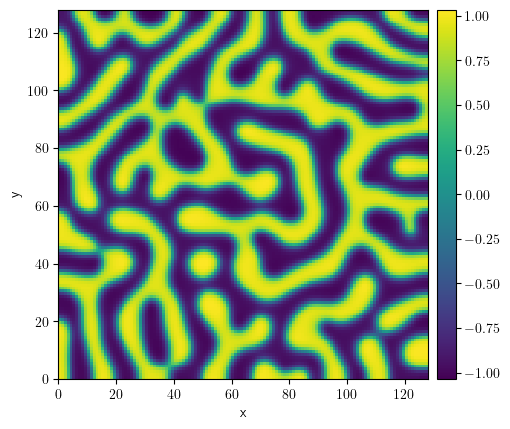

In [59]:
storage = MemoryStorage()
result = eq.solve(
    state=state, t_range=100, dt=0.01, tracker=storage.tracker(interval=10)
)
result.plot()

In [60]:
for field in storage:
    print(f"{field.integral:.3g}, {field.fluctuations:.3g}")

-14.4, 0.291
-14.4, 0.375
-14.4, 0.581
-14.4, 0.642
-14.4, 0.679
-14.4, 0.704
-14.4, 0.722
-14.4, 0.736
-14.4, 0.748
-14.4, 0.758
-14.4, 0.766


In [61]:
storage_write = FileStorage(filename="simulation.hdf")

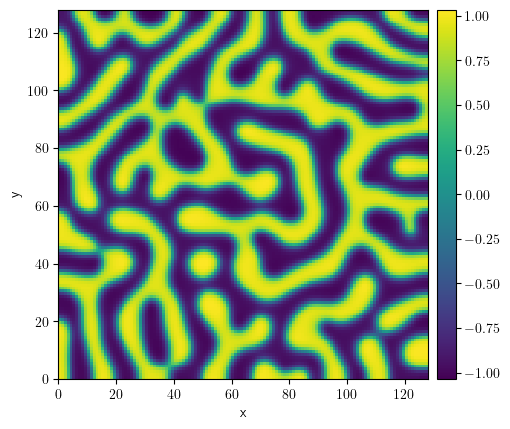

In [62]:
result = eq.solve(
    state=state, t_range=100, dt=0.01, tracker=storage_write.tracker(interval=10)
)
result.plot()

In [63]:
storage_read = FileStorage(filename="simulation.hdf")

In [64]:
for field in storage_read:
    print(f"{field.integral:.3g}, {field.fluctuations:.3g}")

-14.4, 0.291
-14.4, 0.375
-14.4, 0.581
-14.4, 0.642
-14.4, 0.679
-14.4, 0.704
-14.4, 0.722
-14.4, 0.736
-14.4, 0.748
-14.4, 0.758
-14.4, 0.766


## Stochastic

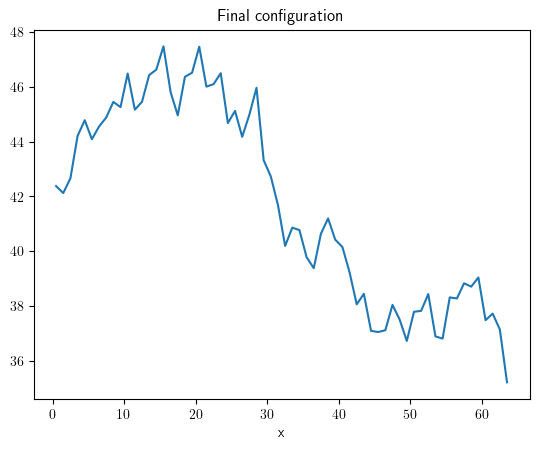

In [65]:
grid = UnitGrid(shape=[64])
state = ScalarField.random_harmonic(grid=grid)
eq = KPZInterfacePDE(noise=1)
storage = MemoryStorage()
result = eq.solve(state=state, t_range=100, dt=0.01, tracker=storage.tracker(1))
result.plot(title="Final configuration")

## Poisson

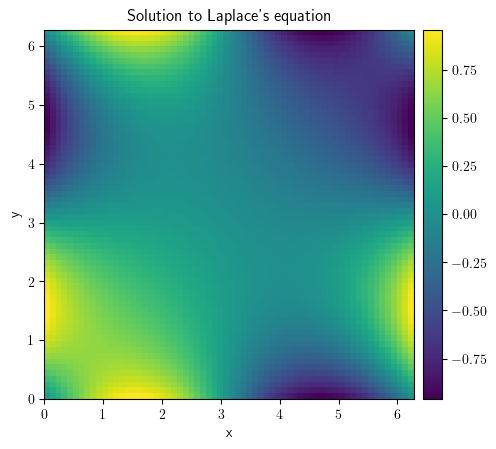

In [66]:
grid = CartesianGrid(bounds=[[0, 2 * np.pi]] * 2, shape=64)
bcs = [{"value": "sin(y)"}, {"value": "sin(x)"}]

field_zero = ScalarField(grid=grid)
result_laplace = solve_poisson_equation(rhs=field_zero, bc=bcs)
result_laplace.plot(title="Solution to Laplace's equation", colorbar=True)

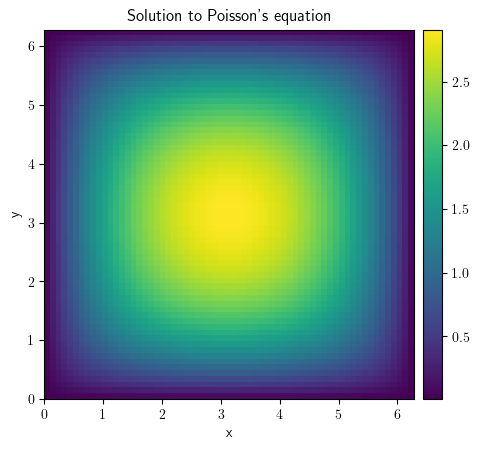

In [67]:
field_one = ScalarField(grid=grid, data=-1)
result_poisson = solve_poisson_equation(rhs=field_one, bc={"value": "0"})
result_poisson.plot(colorbar=True)

In [68]:
result_poisson.laplace(bc={"value": "0"})

ScalarField(grid=CartesianGrid(bounds=((0.0, 6.283185307179586), (0.0, 6.283185307179586)), shape=(64, 64), periodic=[False, False]), data=[[-1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0]
 [-1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0]
 [-1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0]
 ...
 [-1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0]
 [-1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0]
 [-1.0 -1.0 -1.0 ... -1.0 -1.0 -1.0]])

## Diffusion equation

In [69]:
eq = PDE(rhs={"u": "laplace(u)"})
grid = UnitGrid(shape=[64, 64])
state = ScalarField.random_normal(grid=grid, label="Initial state")

In [70]:
sol = eq.solve(state=state, t_range=10, dt=1e-2)
sol.label = "Final state"

  0%|          | 0/10.0 [00:00<?, ?it/s]

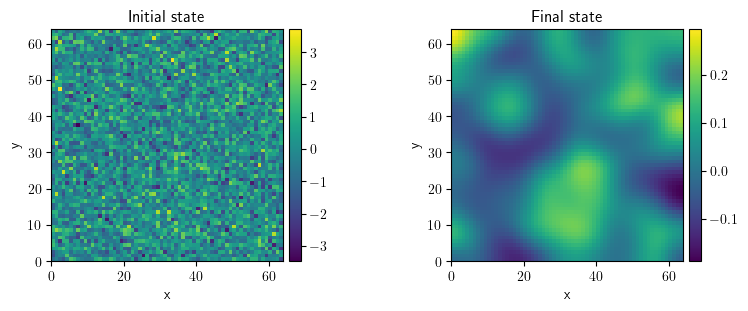

In [71]:
FieldCollection(fields=[state, sol]).plot()

In [72]:
a, b = 1, 3
d0, d1 = 1, 0.1
eq = PDE(
    rhs={
        "u": f"{d0} * laplace(u) + {a} - ({b} + 1) * u + u**2 * v",
        "v": f"{d1} * laplace(v) + {b} * u - u**2 * v",
    }
)

In [73]:
grid = UnitGrid(shape=[64, 64])
u = ScalarField(grid=grid, data=a, label="Field $u$")
v = b / a + 0.1 * ScalarField.random_normal(grid=grid, label="Field $v$")
state = FieldCollection(fields=[u, v])

In [74]:
sol = eq.solve(state=state, t_range=20, dt=1e-3, tracker=PlotTracker())

Output()

Spent more time on handling trackers (49.7) than on the actual simulation (18.6)


In [75]:
class KuramotoSivashinskyPDE(PDEBase):
    """Implementation of the normalized Kuramoto–Sivashinsky equation"""

    def evolution_rate(self, state, t=0):
        """implement the python version of the evolution equation"""
        state_lap = state.laplace(bc="natural")
        state_lap2 = state_lap.laplace(bc="natural")
        state_grad = state.gradient(bc="natural")
        return -state_grad.to_scalar("squared_sum") / 2 - state_lap - state_lap2

In [76]:
grid = UnitGrid(shape=[64, 64])
state = ScalarField.random_uniform(grid=grid)
eq = KuramotoSivashinskyPDE()
result = eq.solve(state=state, t_range=10, dt=0.01)

  0%|          | 0/10.0 [00:00<?, ?it/s]

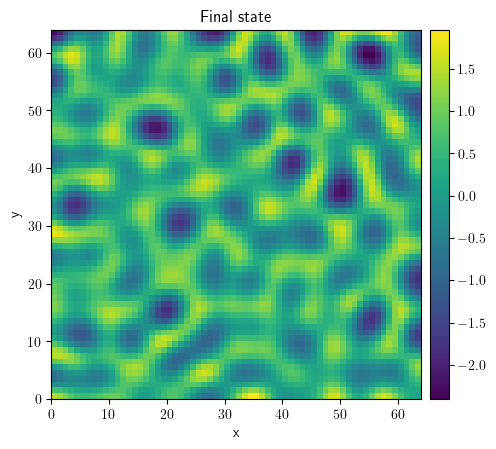

In [77]:
result.plot(title="Final state")

In [78]:
from pprint import pprint

In [79]:
grid = UnitGrid(shape=[32, 32])
field = ScalarField.random_uniform(grid=grid, vmin=-1, vmax=1)
eq = DiffusionPDE()

In [80]:
solver1 = ExplicitSolver(pde=eq)
controller1 = Controller(solver=solver1, t_range=1, tracker=None)
sol1 = controller1.run(initial_state=field, dt=1e-3)
sol1.label = "py-pde"

In [81]:
pprint(controller1.diagnostics)

{'controller': {'jit_count': {'make_stepper': 11, 'simulation': 0},
                'process_count': 1,
                'profiler': {'compilation': 8.14451907800003,
                             'solver': 0.06916966500000399,
                             'tracker': 9.936399999332934e-05},
                'solver_duration': '0:00:00.069640',
                'solver_start': '2023-12-24 12:13:43.516546',
                'stop_reason': 'Reached final time',
                'successful': True,
                't_end': 1.0,
                't_final': 1.0,
                't_start': 0},
 'package_version': '0.33.3',
 'solver': {'backend': 'numba',
            'class': 'ExplicitSolver',
            'dt': 0.001,
            'pde_class': 'DiffusionPDE',
            'scheme': 'euler',
            'state_modifications': 0.0,
            'steps': 1000,
            'stochastic': False}}


In [82]:
solver2 = ScipySolver(pde=eq)
controller2 = Controller(solver=solver2, t_range=1, tracker=None)
sol2 = controller2.run(initial_state=field)
sol2.label = "scipy"

In [83]:
pprint(controller2.diagnostics)

{'controller': {'jit_count': {'make_stepper': 1, 'simulation': 0},
                'process_count': 1,
                'profiler': {'compilation': 1.4118690489999608,
                             'solver': 0.014754138000000694,
                             'tracker': 0.0001679279999962091},
                'solver_duration': '0:00:00.017398',
                'solver_start': '2023-12-24 12:13:45.190866',
                'stop_reason': 'Reached final time',
                'successful': True,
                't_end': 1.0,
                't_final': 1.0,
                't_start': 0},
 'package_version': '0.33.3',
 'solver': {'backend': 'numba',
            'class': 'ScipySolver',
            'dt': None,
            'pde_class': 'DiffusionPDE',
            'steps': 50,
            'stochastic': False}}


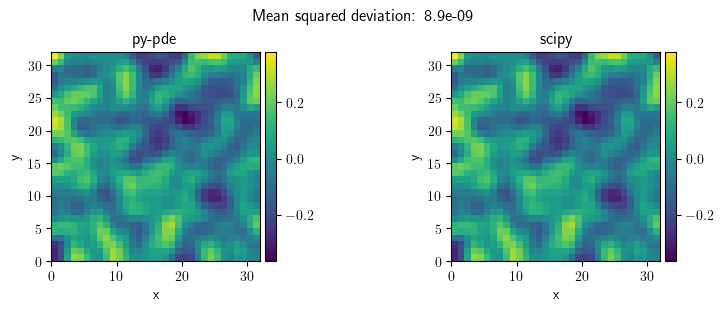

In [84]:
title = f"Mean squared deviation: {((sol1 - sol2)**2).average:.2g}"
FieldCollection(fields=[sol1, sol2]).plot(title=title)

In [85]:
grid = CylindricalSymGrid(radius=5, bounds_z=[0, 16], shape=[15, 16])

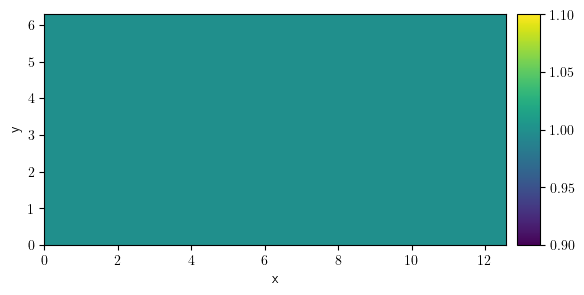

In [86]:
grid = CartesianGrid(bounds=[[0, 4 * np.pi], [0, 2 * np.pi]], shape=[128, 32])
field = ScalarField(grid=grid, data=1)
field.plot()

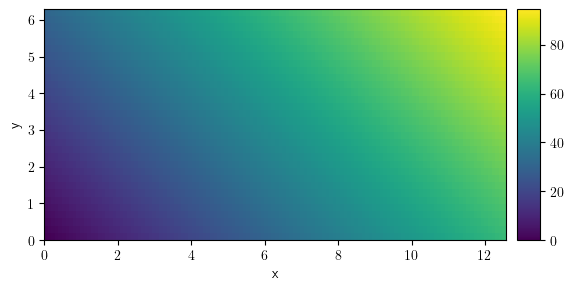

In [87]:
x, y = grid.axes_coords

for i in range(len(x)):
    for j in range(len(y)):
        field.data[i, j] = 0.5 * i + j
field.plot()

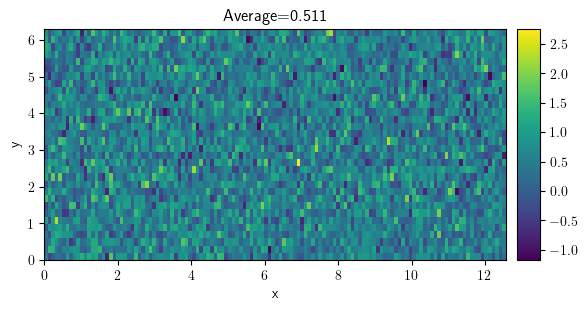

In [88]:
field = ScalarField.random_normal(grid=grid, mean=0.5, std=0.5)
field.plot(title=f"Average={field.average:.3f}", colorbar=True)

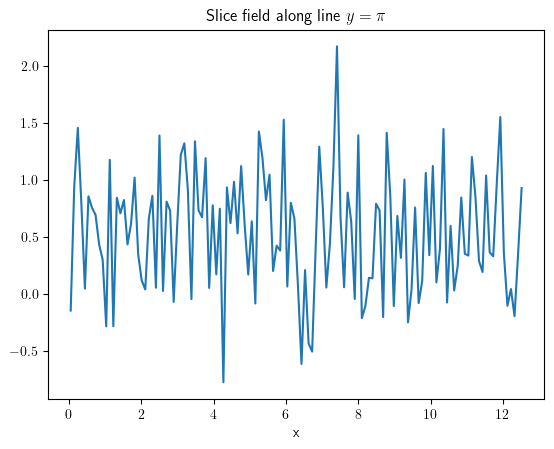

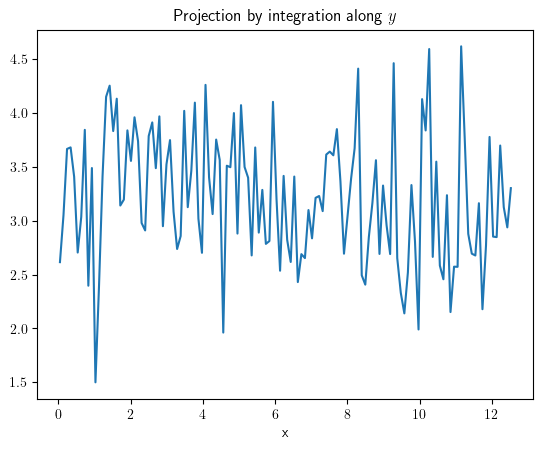

In [89]:
slice_x = field.slice(position={"y": np.pi})
slice_x.plot(title="Slice field along line $y=\pi$")

project_x = field.project(axes="y")
project_x.plot(title="Projection by integration along $y$")

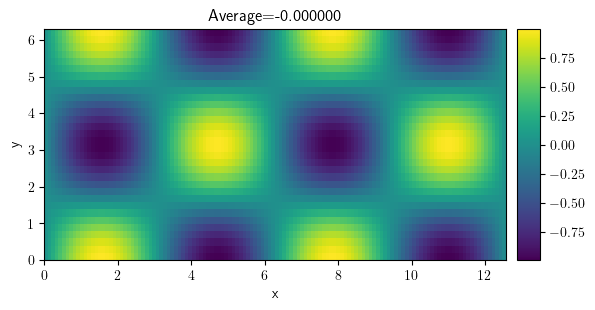

In [90]:
field = ScalarField.from_expression(grid=grid, expression="sin(x) * cos(y)")
field.plot(title=f"Average={field.average:f}", colorbar=True);

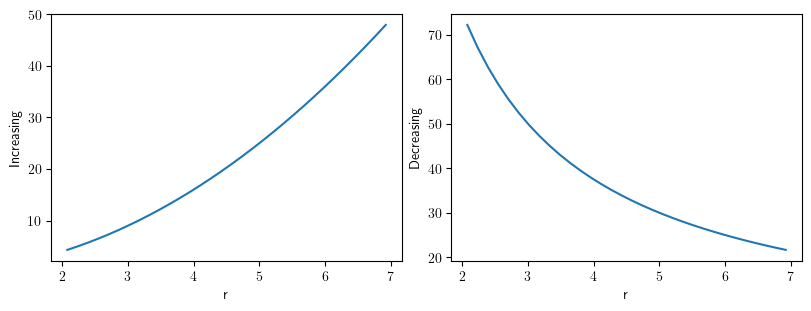

In [91]:
grid_pol = PolarSymGrid(radius=[2, 7], shape=32)
scalar_field1 = ScalarField.from_expression(
    grid=grid_pol, expression="r**2", label="Increasing"
)
scalar_field2 = ScalarField.from_expression(
    grid=grid_pol, expression="150/r", label="Decreasing"
)
collection = FieldCollection(fields=[scalar_field1, scalar_field2])
collection.plot()

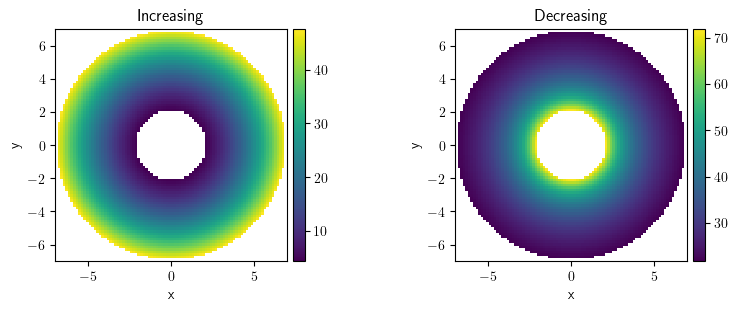

In [92]:
collection.plot("image")

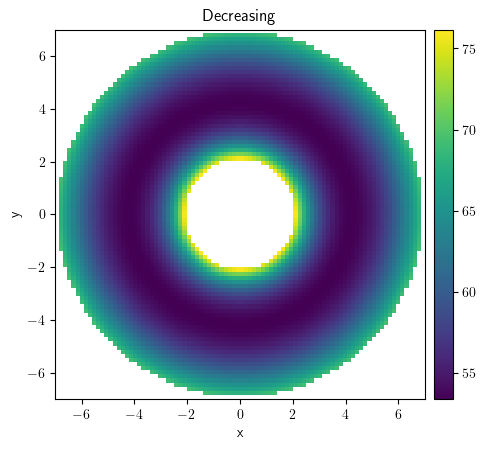

In [93]:
field_sum = collection[0] + collection[1]
field_sum.plot(kind="image")

In [94]:
grid_per = CartesianGrid(
    bounds=[[0, 4 * np.pi], [0, 2 * np.pi]], shape=[128, 32], periodic=True
)
field_per = ScalarField.from_expression(grid=grid_per, expression="sin(x) * cos(y)")

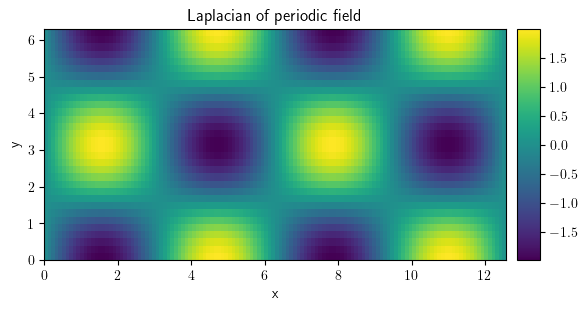

In [95]:
laplace_per = field_per.laplace(bc="periodic")
laplace_per.plot(title="Laplacian of periodic field", colorbar=True)

In [96]:
grid = CartesianGrid(
    bounds=[[0, 4 * np.pi], [0, 2 * np.pi]], shape=[128, 32], periodic=False
)
field = ScalarField.from_expression(grid=grid, expression="sin(x) * cos(y)")

In [97]:
bc_x = ({"value": 0}, {"value": 0})
bc_y = ({"value": 0}, {"value": 0})

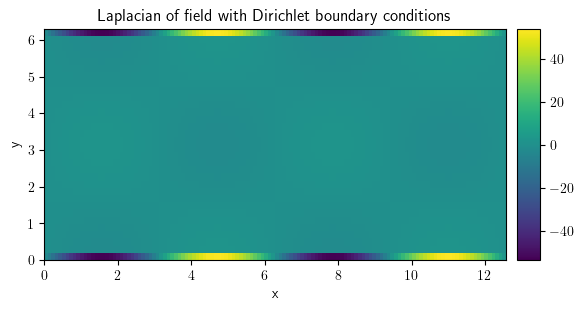

In [98]:
laplace_dir = field.laplace(bc=[bc_x, bc_y])
laplace_dir.plot(
    title="Laplacian of field with Dirichlet boundary conditions", colorbar=True
)

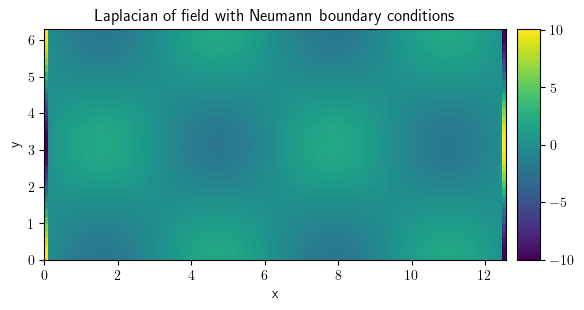

In [99]:
laplace_neu = field.laplace(bc={"derivative": 0})
laplace_neu.plot(
    title="Laplacian of field with Neumann boundary conditions", colorbar=True
)

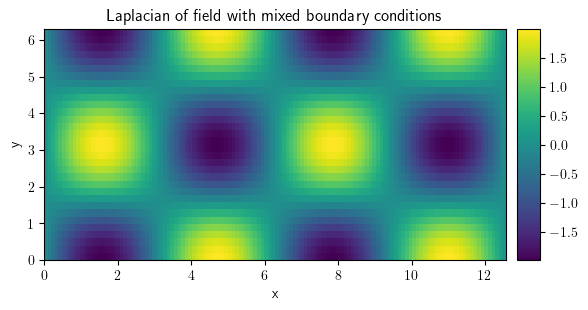

In [100]:
laplace_mix = field.laplace(bc=[{"value": 0}, {"derivative": 0}])
laplace_mix.plot(
    title="Laplacian of field with mixed boundary conditions", colorbar=True
)

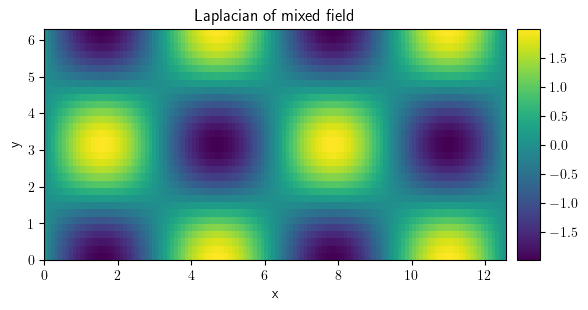

In [101]:
grid_mixed = CartesianGrid(
    bounds=[[0, 4 * np.pi], [0, 2 * np.pi]], shape=[128, 32], periodic=[True, False]
)
field_mixed = ScalarField.from_expression(grid=grid_mixed, expression="sin(x) * cos(y)")

laplace_mixed = field_mixed.laplace(bc=["periodic", {"derivative": 0}])
laplace_mixed.plot(title="Laplacian of mixed field", colorbar=True)

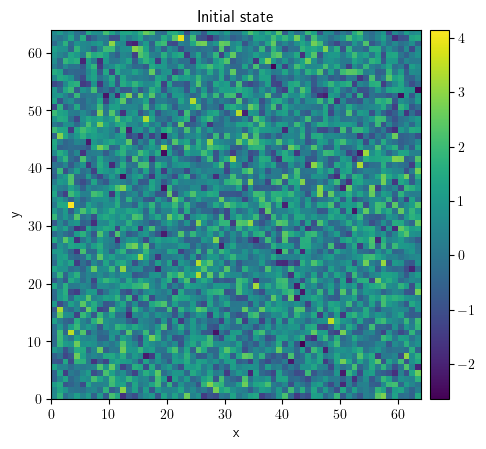

In [102]:
eq = PDE(rhs={"f": "1 * laplace(f)"})
grid = UnitGrid(shape=[64, 64])
state = ScalarField.random_normal(grid=grid, mean=0.5, std=1)
state.plot(title="Initial state")

  0%|          | 0/10.0 [00:00<?, ?it/s]

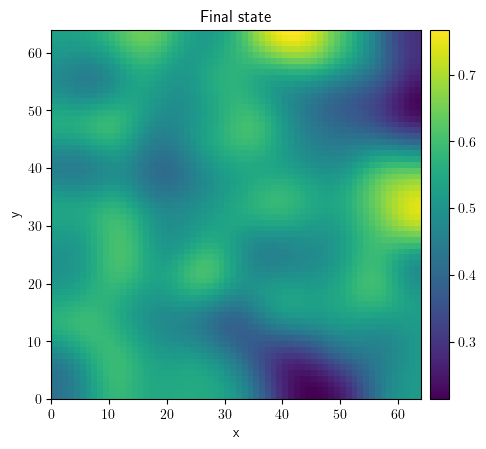

In [103]:
result = eq.solve(state=state, t_range=10, dt=0.1)
result.plot(title="Final state")

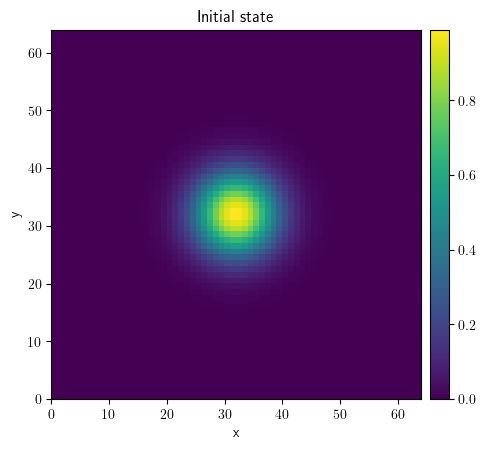

In [104]:
center, width = 32, 50
state = ScalarField.from_expression(
    grid=grid, expression=f"exp(-((x-{center})**2 + (y-{center})**2)/{width})"
)
state.plot(title="Initial state")

  0%|          | 0/100.0 [00:00<?, ?it/s]

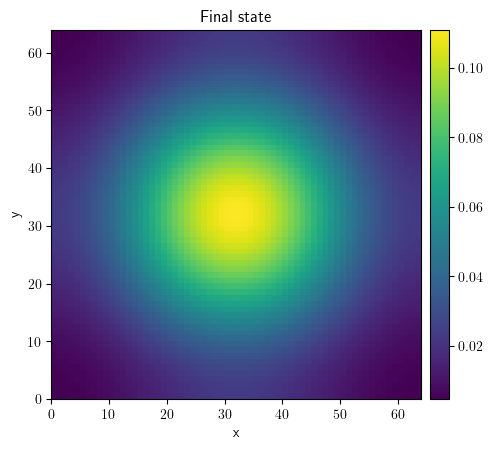

In [105]:
result = eq.solve(state=state, t_range=100, dt=0.1)
result.plot(title="Final state")

In [106]:
bc_x = ({"value": 0}, {"value": 1})
bc_y = ({"derivative": 0}, {"derivative": 0})
eq_dir = PDE(rhs={"f": "laplace(f)"}, bc=[bc_x, bc_y])

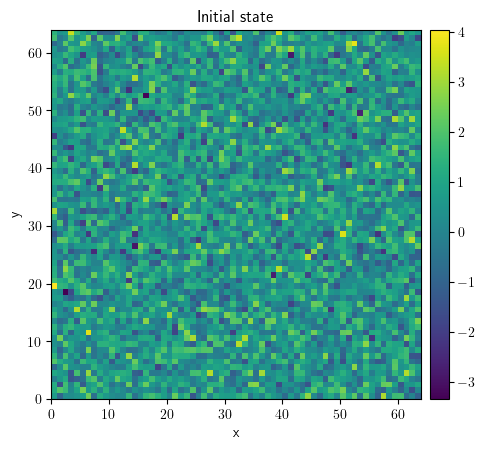

In [107]:
grid = UnitGrid(shape=[64, 64], periodic=False)
state = ScalarField.random_normal(grid=grid, mean=0.5, std=1)
state.plot(title="Initial state")

  0%|          | 0/100.0 [00:00<?, ?it/s]

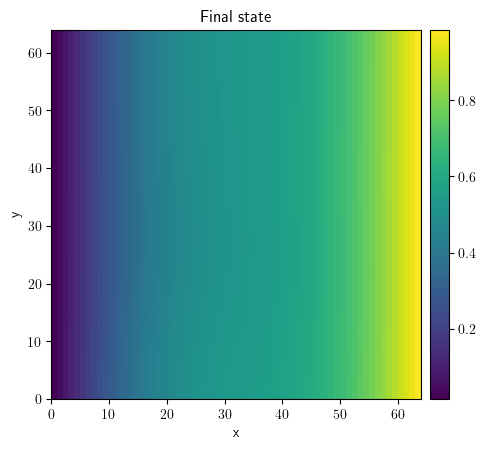

In [108]:
result = eq_dir.solve(state=state, t_range=100, dt=0.1)
result.plot(title="Final state")

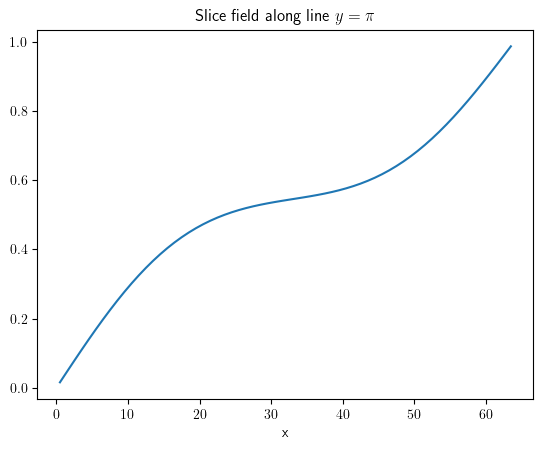

In [109]:
slice_x = result.slice(position={"y": np.pi})
slice_x.plot(title="Slice field along line $y=\pi$")

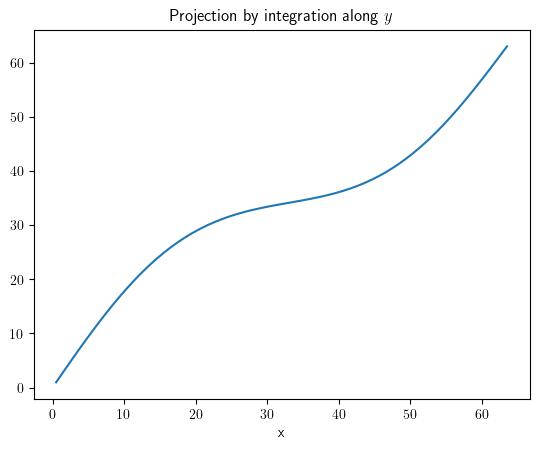

In [110]:
project_x = result.project(axes="y")
project_x.plot(title="Projection by integration along $y$")

In [111]:
field.to_file(filename="random_field.hdf")

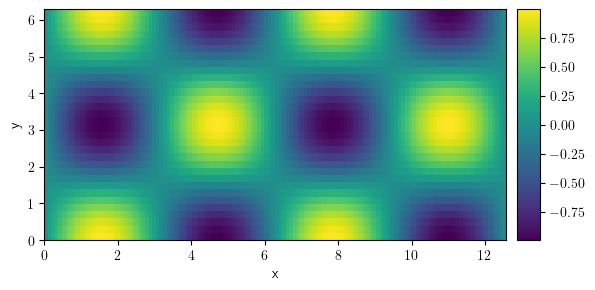

In [112]:
field_loaded = ScalarField.from_file(filename="random_field.hdf")
field_loaded.plot()

In [113]:
import functools
from pde.grids.operators.cartesian import _make_derivative2
import scipy
import datetime

In [114]:
def ETA(step, maxStep, startTime):
    _ETA = None
    total_dt = 0
    dt = 0
    if step == 0:
        _ETA = "Indeterminate"
    else:
        dt = datetime.datetime.now() - startTime
        dt = dt.seconds
        total_dt = dt / step * maxStep
        _ETA = startTime + datetime.timedelta(seconds=total_dt)
        _ETA = str(_ETA.time())

    print(
        f"{int(100 * step / maxStep):>3} % completed. ETA: {_ETA} ({int(total_dt - dt)} seconds remain)."
        + "\t" * 5,
        end="\r",
    )

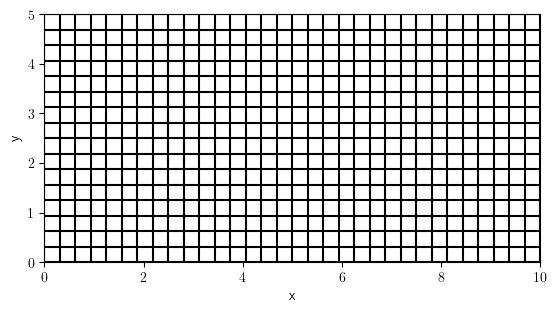

In [115]:
width = 10
height = 5
resolution = (2**5) / 10

grid = CartesianGrid(
    bounds=[[0, width], [0, height]],
    shape=[int(resolution * i) for i in [width, height]],
)
grid.plot()

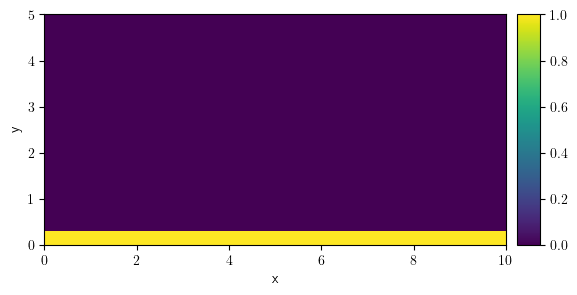

In [116]:
membrane_mask = ScalarField(grid=grid, dtype=float)
membrane_mask.data[:, 0] = 1.0
membrane_mask.plot()

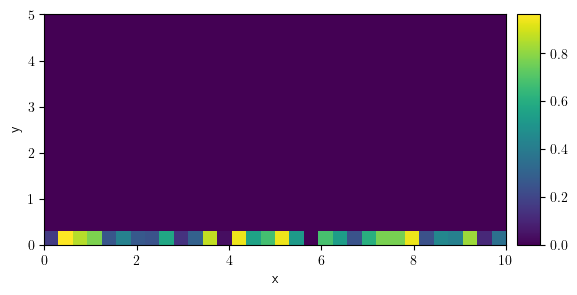

In [117]:
make_laplace_x = functools.partial(_make_derivative2, axis=0)
CartesianGrid.register_operator("laplace_x", make_laplace_x)
c_m = ScalarField.random_uniform(grid=grid)
c_m *= membrane_mask
c_m.plot()

In [119]:
# c_m._apply_operator("laplace_x", bc="natural").plot()